 # MVPA Full 9 emotions


In [1]:
import numpy as np
import nibabel as nb
import os
from nilearn.input_data import NiftiMasker

In [2]:
# define paths
root_dir = '/Volumes/T7/BIDS-BRAINPLAYBACK-TASK2'
fmriprep_dir = os.path.join(root_dir, 'derivatives', 'fmriprep23')
dataset_dir  = os.path.join(root_dir, 'derivatives', 'mvpa_03_full')

# brain masks
#mask_brain_file = os.path.join(root_dir, 'derivatives', 'mni_icbm152_t1_tal_nlin_asym_09c.nii')
mask_gm_file    = os.path.join(root_dir, 'derivatives', 'mni_icbm152_gm_tal_nlin_asym_09c_res-2_dilated.nii')
mask_stab_file  = os.path.join(root_dir, 'derivatives', 'mvpa_03_full_temp', 'STAB_mask.nii.gz')

In [3]:
# list datasets and concatenate

# find all *_dataset.nii.gz files in dataset_dir
dataset_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_full_confounds_dataset.nii.gz') & f.startswith('sub-')]
dataset_files.sort()

# find all *_trial_types.txt files in dataset_dir
label_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.endswith('_full_confounds_trial_types.txt') & f.startswith('sub-')]
label_files.sort()

In [4]:
# get number of subjects
nRunsPerSub = 4
n_subjects = len(dataset_files) / nRunsPerSub
print('Number of subjects found: %d' % n_subjects)

Number of subjects found: 13


In [5]:
# concatenate all datasets
D = nb.concat_images(dataset_files, axis=3)

In [6]:
# concatenate all labels into a single string array
labels = np.concatenate([np.loadtxt(l, dtype=str) for l in label_files])

# trim each label to remove the 2 digit number in the end
labels = np.array([l[:-2] for l in labels])

In [7]:
# Load mask
#masker = NiftiMasker(mask_img=mask_gm_file, standardize=False, detrend=False)
masker = NiftiMasker(mask_img=mask_stab_file, standardize=False, detrend=False)
samples = masker.fit_transform(D)

In [8]:
# generate an array of chunk labels
# 13 subjects, 9 x 2 music for each of the 4 runs
chunks = np.repeat(np.arange(1,14), 9*2*4)

In [9]:
# Let's specify the classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(multi_class="ovr", max_iter=1000, class_weight='balanced', dual='auto')


# Manual Leave one subject out cross validation

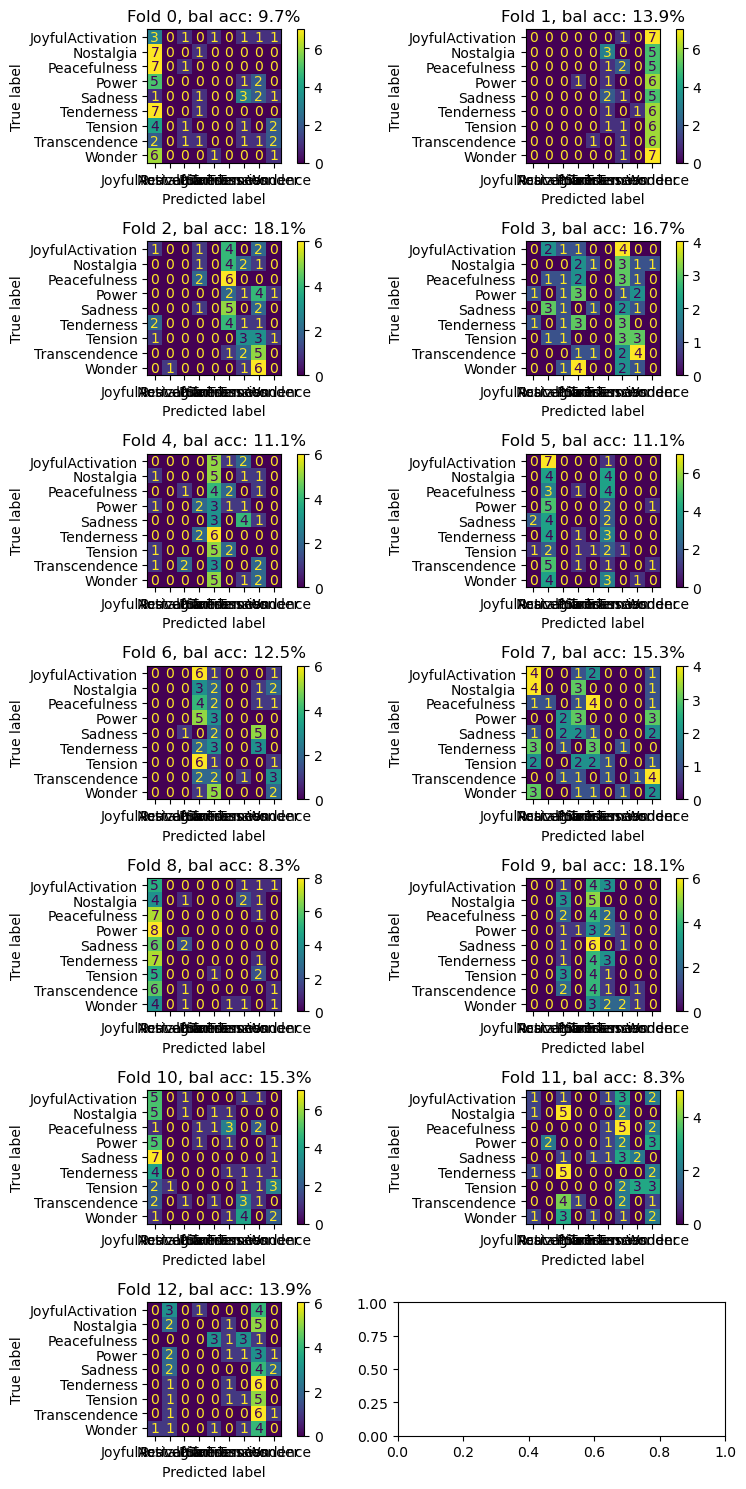

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

n_folds = 13
acc_array = np.zeros(n_folds)
acc_bal_array = np.zeros(n_folds)

fig, ax = plt.subplots(7, 2, figsize=(8, 15))

for ff in range(n_folds):
    # split the data into training and test set
    train_mask = chunks != ff+1
    test_mask = chunks == ff+1

    X_train = samples[train_mask]
    y_train = labels[train_mask]
    X_test = samples[test_mask]
    y_test = labels[test_mask]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute the prediction accuracy for the different labels
    acc_array[ff] = (y_pred == y_test).mean()
    acc_bal_array[ff] = balanced_accuracy_score(y_test, y_pred)

    # Confusion matrix plots
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax[ff // 2, ff % 2])
    ax[ff // 2, ff % 2].set_title(f"Fold {ff}, bal acc: {acc_bal_array[ff]*100:0.1f}%")

plt.tight_layout()

In [11]:
print(f"Mean accuracy: {acc_array.mean()*100:0.1f}% \u00B1 {acc_array.std()*100:0.1f}%")
#print(f"Mean balanced accuracy: {acc_bal_array.mean()*100:0.1f}% \u00B1 {acc_bal_array.std()*100:0.1f}%")

Mean accuracy: 13.2% ± 3.3%


In [12]:
from sklearn.model_selection import cross_validate, LeaveOneGroupOut
clf = LinearSVC(multi_class="ovr", max_iter=1000, class_weight='balanced', dual='auto')

# search for better C
from sklearn.model_selection import GridSearchCV
param_grid = {'C': np.linspace(0.00001, 1000, 100)}
grid_search = GridSearchCV(clf, param_grid, cv=LeaveOneGroupOut(), n_jobs=6, scoring='balanced_accuracy')
grid_search.fit(samples, labels, groups=chunks)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'C': 10.10102}
Best score: 0.13247863247863248


In [13]:
#from sklearn.linear_model import LogisticRegression
#clf = LogisticRegression(class_weight='balanced', max_iter=1000)
cv_scores = cross_validate(estimator=grid_search.best_estimator_,
                X=samples,
                y=labels,
                groups=chunks,
                cv=LeaveOneGroupOut(),
                n_jobs=6,
                return_train_score=True,
                return_estimator = True,
                verbose=1)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  13 out of  13 | elapsed:    0.2s finished


In [14]:
cv_scores['train_score'], cv_scores['test_score']

(array([0.44791667, 0.42476852, 0.44212963, 0.43402778, 0.44560185,
        0.46180556, 0.44212963, 0.43055556, 0.45023148, 0.4537037 ,
        0.43634259, 0.42361111, 0.43287037]),
 array([0.09722222, 0.13888889, 0.18055556, 0.16666667, 0.11111111,
        0.11111111, 0.125     , 0.15277778, 0.08333333, 0.18055556,
        0.15277778, 0.08333333, 0.13888889]))